<a href="https://colab.research.google.com/github/ranna-waleed/DSAI-305_Loan-Default-Prediction/blob/main/XAI_loan_prediction_Decision_Tree_Rana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries and Setup

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
import os
from imblearn.over_sampling import SMOTE

In [ ]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
# Set random seed
random_seed = 42
np.random.seed(random_seed)

In [ ]:
# Create output directory
os.makedirs('model_outputs_dt', exist_ok=True)

Load and Prepare Data

In [ ]:
print("\nLoading preprocessed data...")
df = pd.read_csv('final_loan_data_leakproof.csv')
print("Dataset shape:", df.shape)
print("Columns in dataset:", df.columns.tolist())


Loading preprocessed data...
Dataset shape: (50000, 31)
Columns in dataset: ['loan_amnt', 'installment', 'int_rate', 'grade', 'sub_grade', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'issue_d_year', 'issue_d_month', 'earliest_cr_line_year', 'earliest_cr_line_month', 'int_rate_grade', 'loan_to_income', 'dti_ratio', 'credit_history_years', 'income_bin', 'term_ 60 months', 'emp_length_10+ years', 'home_ownership_MORTGAGE', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_debt_consolidation', 'target']


In [ ]:
# Separate features and target
X = df.drop(columns=['target'])
y = df['target']

In [ ]:
# Encode categorical variables
cat_cols = X.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    le = LabelEncoder()
    for col in cat_cols:
        X[col] = le.fit_transform(X[col].astype(str))
    print(f"Encoded {len(cat_cols)} categorical columns.")

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (40000, 30)
Testing set shape: (10000, 30)


In [ ]:
# Reset indices
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)

# Apply SMOTE to balance training set
print("\nApplying SMOTE to balance training set...")
smote = SMOTE(random_state=random_seed)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced training set shape:", X_train_balanced.shape)
print("Class distribution after SMOTE:", y_train_balanced.value_counts().to_dict())


Applying SMOTE to balance training set...
Balanced training set shape: (63814, 30)
Class distribution after SMOTE: {0: 31907, 1: 31907}


In [ ]:
# Convert to numpy arrays
X_test_np = X_test.values
X_train_np = X_train_balanced.values
y_train_np = y_train_balanced.values

Model Building and Training

In [ ]:
# Create pipeline with scaler and Decision Tree classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier(random_state=random_seed))
])

# parameter grid for GridSearchCV
param_grid = {
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5]
}

In [ ]:
# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_np, y_train_np)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5, 10, None],
                         'model__min_samples_split': [2, 5]},
             scoring='roc_auc', verbose=1)

In [ ]:
# Best model
best_pipeline = grid_search.best_estimator_
best_model = best_pipeline.named_steps['model']
print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC score:", grid_search.best_score_)

# Save model
with open('model_outputs_dt/decisiontree_pipeline.pkl', 'wb') as f:
    pickle.dump(best_pipeline, f)
print("Pipeline saved as 'model_outputs_dt/decisiontree_pipeline.pkl'")

Best parameters: {'model__max_depth': 10, 'model__min_samples_split': 5}
Best ROC-AUC score: 0.8941849287468461
Pipeline saved as 'model_outputs_dt/decisiontree_pipeline.pkl'


Model Evaluation

In [ ]:
# Predict probabilities and adjust threshold
threshold = 0.5
y_pred_proba = best_pipeline.predict_proba(X_test_np)[:, 1]
y_pred = (y_pred_proba >= threshold).astype(int)

In [ ]:
# Calculate metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

# Print metrics
print("\nModel Performance Metrics (threshold = 0.5):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Model Performance Metrics (threshold = 0.5):
Accuracy: 0.7876
Precision: 0.4385
Recall: 0.1780
F1-Score: 0.2532
ROC-AUC: 0.6905


**Observation**
- The model, with a threshold of 0.5, achieves an accuracy of 0.7876 and an ROC-AUC of 0.6905, but its low recall (0.1780) and F1-score (0.2532) suggest it struggles to identify positive cases, despite a moderate precision of 0.4385.

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      7977
           1       0.44      0.18      0.25      2023

    accuracy                           0.79     10000
   macro avg       0.63      0.56      0.56     10000
weighted avg       0.74      0.79      0.75     10000



<Figure size 800x600 with 0 Axes>

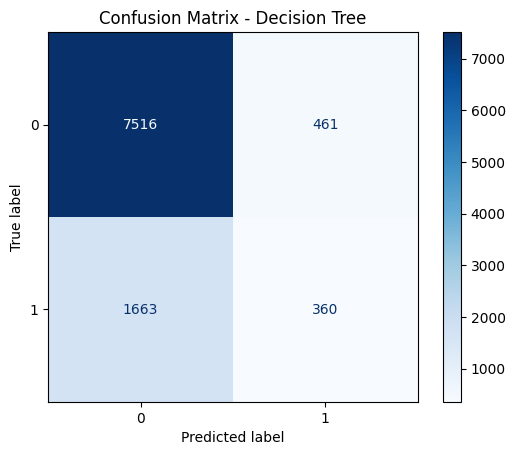

Confusion matrix saved as 'model_outputs_dt/confusion_matrix.png'


In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.savefig('model_outputs_dt/confusion_matrix.png')
plt.show()
plt.close()
print("Confusion matrix saved as 'model_outputs_dt/confusion_matrix.png'")

**Observation**
- The confusion matrix for the Decision Tree model shows 7516 true negatives, 461 false positives, 1663 false negatives, and 360 true positives, indicating high accuracy but a notable number of missed positive cases.

In [ ]:
# Save metrics
with open('model_outputs_dt/evaluation_metrics.txt', 'w') as f:
    for metric, value in metrics.items():
        f.write(f"{metric}: {value:.4f}\n")
print("Evaluation metrics saved as 'model_outputs_dt/evaluation_metrics.txt'")

Evaluation metrics saved as 'model_outputs_dt/evaluation_metrics.txt'


Explainability Techniques

SHAP Values

SHAP values shape: (100, 30)
X_test_sample shape: (100, 30)


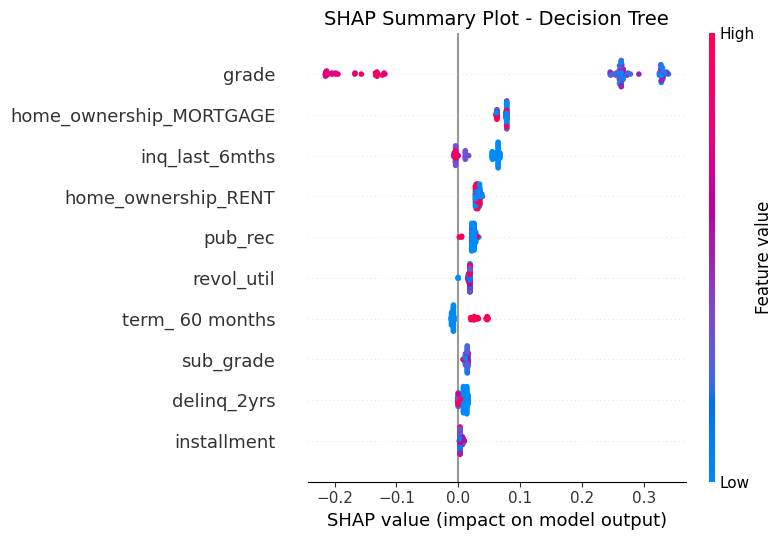

SHAP summary plot saved as 'model_outputs_dt/shap_summary.png'


In [ ]:
# Use a small subset of test data for SHAP
X_test_sample = X_test.sample(n=100, random_state=random_seed)
X_test_sample_np = X_test_sample.values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_sample_np)[:, :, 1]  # Select positive class for binary classification

# Verify shapes
print(f"SHAP values shape: {np.array(shap_values).shape}")
print(f"X_test_sample shape: {X_test_sample.shape}")

# SHAP Beeswarm Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, max_display=10, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot - Decision Tree", fontsize=14)
plt.tight_layout()
plt.savefig('model_outputs_dt/shap_summary.png')
plt.show()
plt.close()
print("SHAP summary plot saved as 'model_outputs_dt/shap_summary.png'")

**Observation**
- The SHAP Summary Plot for the Decision Tree model shows grade and home_ownership_MORTGAGE as the most impactful features, with positive SHAP values (red dots) indicating higher feature values increase the prediction, while features like installment have minimal influence.

Permutation Feature Importance

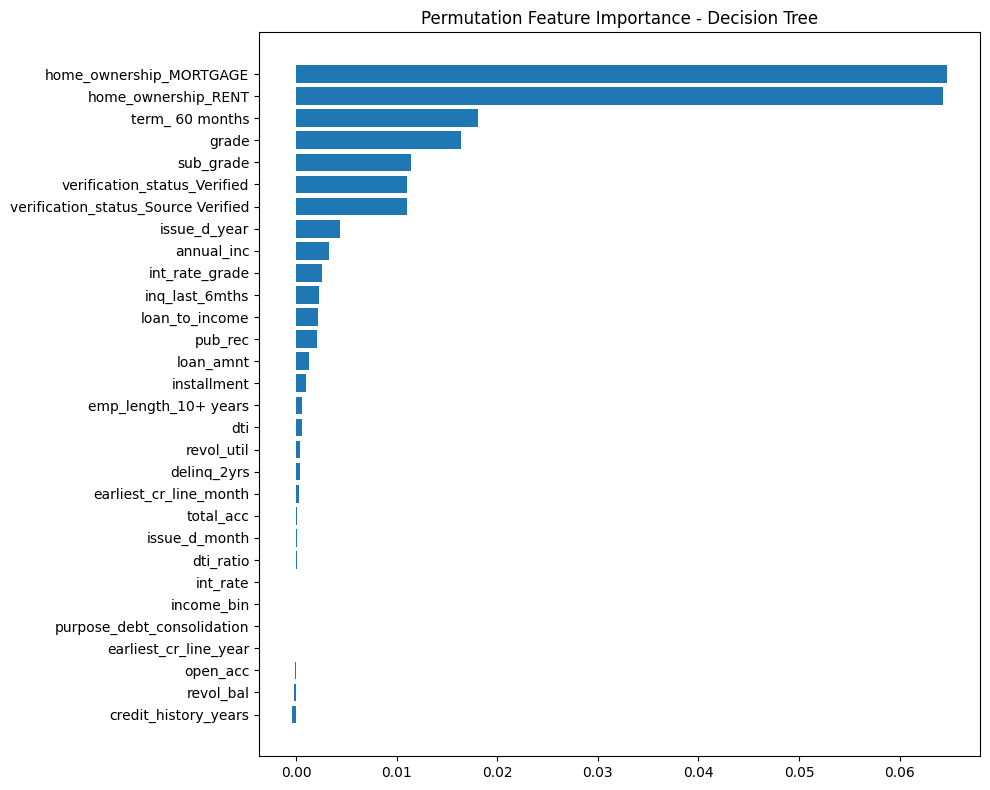

Permutation importance plot saved as 'model_outputs_dt/permutation_importance.png'


In [ ]:
perm_importance = permutation_importance(best_pipeline, X_test_np, y_test, n_repeats=5, random_state=random_seed)
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.figure(figsize=(10, 8))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title('Permutation Feature Importance - Decision Tree')
plt.tight_layout()
plt.savefig('model_outputs_dt/permutation_importance.png')
plt.show()
plt.close()
print("Permutation importance plot saved as 'model_outputs_dt/permutation_importance.png'")

**Observation**
- The Permutation Feature Importance plot for the Decision Tree model shows home_ownership_MORTGAGE and term_60_months as the most influential features, followed by grade and sub_grade, while features like revol_bal and credit_history_years have minimal impact.

Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) for 'grade'

Feature 'grade' found at index: 3


<Figure size 1000x500 with 0 Axes>

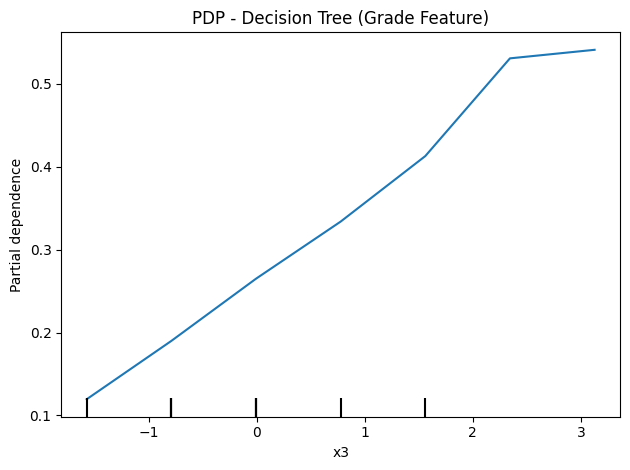

PDP plot for 'grade' saved as 'model_outputs_dt/pdp_grade.png'


In [ ]:
# Find the index of the 'grade' feature
grade_index = X.columns.get_loc('grade')
print(f"Feature 'grade' found at index: {grade_index}")

# Transform X_test using the pipeline's scaler
X_test_scaled = best_pipeline.named_steps['scaler'].transform(X_test)

# PDP for 'grade'
plt.figure(figsize=(10, 5))
PartialDependenceDisplay.from_estimator(
    best_pipeline.named_steps['model'],
    X_test_scaled,
    features=[grade_index],
    kind='average',
    grid_resolution=20
)
plt.title("PDP - Decision Tree (Grade Feature)")
plt.tight_layout()
plt.savefig('model_outputs_dt/pdp_grade.png')
plt.show()
plt.close()
print("PDP plot for 'grade' saved as 'model_outputs_dt/pdp_grade.png'")

**Observation**
- The PDP for the Decision Tree model (Grade Feature) shows a steady increase in partial dependence from 0.1 to 0.5 as x3
  rises from -1 to 3, indicating a consistent positive relationship with the target variable.

ICE for 'grade'

<Figure size 1000x500 with 0 Axes>

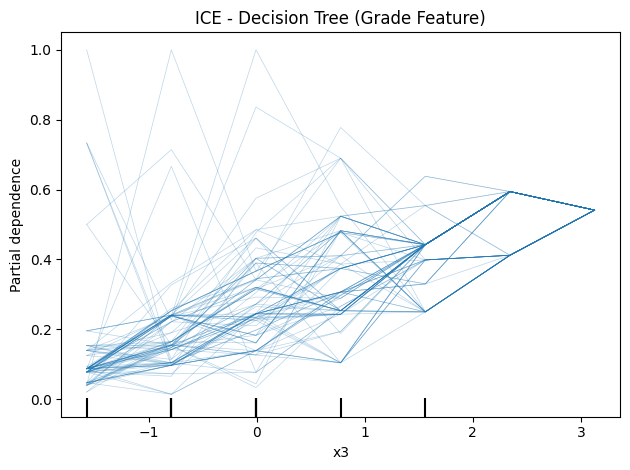

ICE plot for 'grade' saved as 'model_outputs_dt/ice_grade.png'


In [ ]:
plt.figure(figsize=(10, 5))
PartialDependenceDisplay.from_estimator(
    best_pipeline.named_steps['model'],
    X_test_scaled,
    features=[grade_index],
    kind='individual',
    grid_resolution=20,
    subsample=100
)
plt.title("ICE - Decision Tree (Grade Feature)")
plt.tight_layout()
plt.savefig('model_outputs_dt/ice_grade.png')
plt.show()
plt.close()
print("ICE plot for 'grade' saved as 'model_outputs_dt/ice_grade.png'")

**Observation**
- The ICE plot for the Decision Tree model (Grade Feature) shows that as x3
  increases from -1 to 3, the partial dependence generally rises from around 0.2 to 0.8, with some variability, indicating a positive relationship with the target variable.